# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [1]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

Let's define a timer class to easily benchmark the calculations:

In [2]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [3]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.005742 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [4]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in ['node', 'line', 'source', 'sym_load']:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'data/{component}.csv')

        # Initialize array
        input_data[component] = initialize_array('input', component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


node     : 2001
line     : 2000
source   :    1
sym_load : 2000
Execution time for Loading Input Data is 0.058388 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/alliander-opensource/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [5]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.007695 s


# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [6]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.000670 s
{'line': 2000, 'node': 2001, 'source': 1, 'sym_load': 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [7]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.005929 s
Min line loading: 0.14188449783808707
Max line loading: 1.6292378285645808


In [8]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Linear Power Flow is 0.001179 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [9]:
# Generate random load profile
n_scenarios = 1000
dti = pd.date_range("2018-01-01", periods=n_scenarios, freq="H")
n_loads = len(input_data["sym_load"]) 
load_id = input_data["sym_load"]["id"]
load_p = input_data["sym_load"]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 1e4 * np.random.randn(n_scenarios, n_loads)
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2018-01-01 00:00:00,9.945599e+05,1.041684e+06,917565.178151,953915.228358,1.072697e+06,888155.989698,927415.779696,1.039391e+06,1.029092e+06,1.001758e+06,...,1.003769e+06,1.074855e+06,1.046026e+06,914328.798217,907404.644558,1.000042e+06,928313.976708,1.107036e+06,897828.455406,1.071409e+06
2018-01-01 01:00:00,1.002132e+06,1.040067e+06,912325.293546,977381.957317,1.078562e+06,891101.852834,917737.926692,1.060542e+06,1.038038e+06,1.012885e+06,...,1.006510e+06,1.067673e+06,1.025927e+06,909232.376507,912675.826136,9.867087e+05,919766.424370,1.095405e+06,920061.197395,1.069219e+06
2018-01-01 02:00:00,9.918990e+05,1.046100e+06,912997.339072,991849.331619,1.076158e+06,909703.979458,941966.206894,1.056047e+06,1.028182e+06,1.015341e+06,...,9.978840e+05,1.083381e+06,1.054217e+06,925035.884155,934076.454885,9.798753e+05,926195.748568,1.091934e+06,936486.600761,1.080378e+06
2018-01-01 03:00:00,9.738940e+05,1.020814e+06,905015.866597,971767.634151,1.066602e+06,902368.166473,925426.594150,1.044138e+06,1.002681e+06,1.025897e+06,...,1.000975e+06,1.075322e+06,1.041441e+06,920049.799854,908549.783588,9.986496e+05,935855.742626,1.100411e+06,925198.206030,1.075720e+06
2018-01-01 04:00:00,9.893541e+05,1.033818e+06,915120.968967,976964.222814,1.078648e+06,915957.774409,940731.191879,1.063412e+06,1.014474e+06,1.017948e+06,...,1.000361e+06,1.068645e+06,1.045259e+06,927289.496167,908232.500539,9.872863e+05,937521.058176,1.091204e+06,937717.844501,1.091010e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-11 11:00:00,1.001638e+06,1.036437e+06,914940.666982,970810.946841,1.069544e+06,912541.618652,929810.951823,1.052737e+06,1.024649e+06,1.016694e+06,...,1.010589e+06,1.076447e+06,1.045666e+06,907051.242469,906106.200615,9.981430e+05,946092.569315,1.094296e+06,924899.432092,1.094461e+06
2018-02-11 12:00:00,9.985839e+05,1.041600e+06,909647.918186,962563.724200,1.062882e+06,917874.212192,947980.017365,1.047707e+06,1.033082e+06,1.042587e+06,...,9.934169e+05,1.078828e+06,1.036842e+06,917555.977543,904550.246218,9.720571e+05,936114.777198,1.087778e+06,922675.256090,1.086314e+06
2018-02-11 13:00:00,9.905896e+05,1.041010e+06,921292.850395,971657.693603,1.060724e+06,918296.725694,946196.140821,1.049701e+06,1.000049e+06,1.016186e+06,...,1.003475e+06,1.075035e+06,1.051299e+06,923044.186282,902036.411528,9.940661e+05,936940.693203,1.089391e+06,934713.405708,1.086824e+06
2018-02-11 14:00:00,1.000643e+06,1.050226e+06,894347.626513,963752.262505,1.081493e+06,904263.507181,938554.229643,1.051617e+06,1.014540e+06,1.031799e+06,...,9.934242e+05,1.075809e+06,1.054091e+06,923783.351365,898303.624403,9.908984e+05,927419.329170,1.098270e+06,923728.950736,1.099953e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [10]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data["sym_load"]) 
load_id = input_data["sym_load"]["id"]
load_p = input_data["sym_load"]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 1e4 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="H")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,9.906100e+05,1.029147e+06,928978.816839,961643.861986,1.072367e+06,918036.062267,923190.418468,1.067649e+06,1.012604e+06,1.010350e+06,...,1.013107e+06,1.090994e+06,1.034541e+06,938557.847025,909272.846001,9.831404e+05,941429.244483,1.098389e+06,931329.153095,1.095299e+06
2022-01-01 01:00:00,9.970063e+05,1.026632e+06,913331.832858,953775.056678,1.068773e+06,888473.273445,912626.571725,1.072542e+06,1.005952e+06,1.015072e+06,...,9.988504e+05,1.076699e+06,1.042423e+06,924561.229155,876068.388000,1.008284e+06,945115.445669,1.110421e+06,918151.152526,1.085134e+06
2022-01-01 02:00:00,9.782582e+05,1.030902e+06,913910.831793,959223.990808,1.056620e+06,904281.483192,925842.345484,1.061350e+06,1.014681e+06,1.022842e+06,...,1.015720e+06,1.066146e+06,1.045011e+06,915322.737237,911208.867845,9.806859e+05,945273.462012,1.088491e+06,916412.618231,1.090920e+06
2022-01-01 03:00:00,9.874969e+05,1.025104e+06,913405.618802,960328.868205,1.075751e+06,909841.274333,915000.593437,1.066542e+06,1.027313e+06,1.001285e+06,...,1.029373e+06,1.081973e+06,1.052474e+06,930056.043070,910706.888414,9.856062e+05,923534.101222,1.079641e+06,935106.423375,1.085987e+06
2022-01-01 04:00:00,9.793894e+05,1.046289e+06,903676.704092,976220.290682,1.068383e+06,885705.063742,940179.419429,1.048791e+06,1.005253e+06,1.030171e+06,...,1.005254e+06,1.077346e+06,1.047952e+06,914017.955216,910161.536717,9.880463e+05,932891.301297,1.091803e+06,932554.201857,1.094370e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,9.885285e+05,1.058254e+06,920999.138089,972004.971049,1.062347e+06,913462.311049,934102.766693,1.066907e+06,1.013056e+06,1.009933e+06,...,1.005755e+06,1.082639e+06,1.054042e+06,916515.095672,913969.561543,9.915243e+05,934917.207819,1.100355e+06,927853.790624,1.088224e+06
2022-02-11 12:00:00,9.881343e+05,1.048678e+06,899959.725152,953937.267703,1.060146e+06,901937.273408,927003.292240,1.052068e+06,1.013793e+06,1.010649e+06,...,1.006787e+06,1.090786e+06,1.060161e+06,925576.205836,908210.088760,9.772544e+05,945189.245408,1.076168e+06,930690.821035,1.074138e+06
2022-02-11 13:00:00,1.001643e+06,1.041888e+06,907607.459967,966009.044724,1.075476e+06,900982.888003,929578.967314,1.048586e+06,1.014330e+06,1.010716e+06,...,1.010250e+06,1.070614e+06,1.043977e+06,927608.528218,901767.138147,9.905953e+05,950664.955377,1.085592e+06,918512.709463,1.087058e+06
2022-02-11 14:00:00,1.020103e+06,1.048289e+06,915191.156196,968910.382412,1.078065e+06,880448.097546,926152.573525,1.046062e+06,1.031770e+06,1.005744e+06,...,9.821787e+05,1.081174e+06,1.039661e+06,921846.263335,905249.484196,9.843742e+05,930396.369839,1.112109e+06,921823.243499,1.089379e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [11]:
# Initialize an empty load profile
load_profile = initialize_array("update", "sym_load", df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {"sym_load": load_profile}

In [12]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 1.613053 s


In [13]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 2.320341 s


In [14]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 0.273289 s


## Plotting batch results

Lets say we wish to plot the loading of the `line 7` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

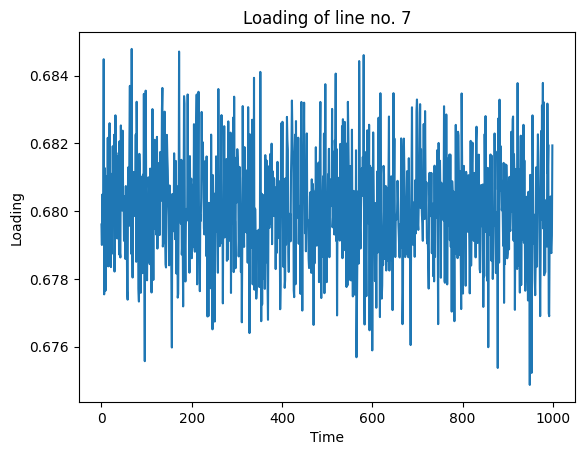

In [15]:
result_loading = output_data["line"]["loading"][:,6]
plt.plot(result_loading)
plt.title('Loading of line no. 7')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line 7` is greater than `68.4%`

In [16]:
ind = np.where(result_loading > 0.684)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-01 05:00:00', '2022-01-03 19:00:00',
               '2022-01-08 04:00:00', '2022-01-15 16:00:00',
               '2022-01-22 15:00:00', '2022-01-24 19:00:00',
               '2022-01-25 05:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [17]:
n_lines = len(input_data["line"])

# Initialize an empty line profile
line_profile = initialize_array("update", "line", (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data["line"]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {"line": line_profile}

In [18]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 3.140171 s


In [19]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 5.268639 s


In [20]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 1.531592 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [ ]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)